In [1]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import datetime
import os
import sys
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
# load data for covide cases
daily_cases = pd.read_csv("./data/us-counties-covid-cases.csv")
daily_cases = daily_cases[daily_cases["state"] == "North Carolina"]
daily_cases.head()

,date,county,state,fips,cases,deaths
483,2020-03-03,Wake,North Carolina,37183.0,1,0.0
520,2020-03-04,Wake,North Carolina,37183.0,1,0.0
567,2020-03-05,Wake,North Carolina,37183.0,1,0.0
630,2020-03-06,Chatham,North Carolina,37037.0,1,0.0
631,2020-03-06,Wake,North Carolina,37183.0,1,0.0


<IPython.core.display.Javascript object>

In [3]:
# check unique counties
daily_cases.county.unique()

array(['Wake', 'Chatham', 'Cabarrus', 'Forsyth', 'Johnston',
       'Mecklenburg', 'Onslow', 'Wayne', 'Brunswick', 'Craven', 'Harnett',
       'Watauga', 'Wilson', 'Durham', 'Iredell', 'Sampson', 'Gaston',
       'Guilford', 'Hoke', 'Lincoln', 'Moore', 'New Hanover', 'Carteret',
       'Davidson', 'Franklin', 'Orange', 'Pasquotank', 'Pitt', 'Rowan',
       'Stanly', 'Buncombe', 'Catawba', 'Cherokee', 'Cumberland', 'Davie',
       'Granville', 'Henderson', 'Lee', 'Nash', 'Robeson', 'Scotland',
       'Union', 'Alamance', 'Vance', 'Montgomery', 'Randolph',
       'Transylvania', 'Bertie', 'Burke', 'Caldwell', 'Cleveland',
       'Duplin', 'Hertford', 'Lenoir', 'McDowell', 'Northampton',
       'Beaufort', 'Greene', 'Person', 'Surry', 'Edgecombe', 'Perquimans',
       'Polk', 'Alleghany', 'Caswell', 'Columbus', 'Currituck', 'Halifax',
       'Pamlico', 'Washington', 'Yadkin', 'Alexander', 'Rutherford',
       'Anson', 'Clay', 'Martin', 'Rockingham', 'Wilkes', 'Dare', 'Gates',
       'Maco

<IPython.core.display.Javascript object>

In [4]:
# remove uknown counties
daily_cases = daily_cases[daily_cases['county']!='Unknown']

<IPython.core.display.Javascript object>

In [5]:
# load population data
pop =  pd.read_excel("./co-est2019-annres.xlsx",  header=[0,1,2,3])
pop.columns = pop.columns.droplevel([0,1,2])
pop.rename(columns={"Unnamed: 0_level_3": "Geographic Area"}, inplace = True)
pop["Geographic Area"] = pop["Geographic Area"].str.replace('.','', regex=True)

# subset population data to NC counties
pop = pop[pop['Geographic Area'].str.contains("North Carolina")]

# use 2019 population
pop = pop.iloc[:, [0] + [-1]]

# rename county column
pop['Geographic Area'] = pop['Geographic Area'].str.replace(' County, North Carolina', '')

# rename dataframe columnes 
pop.columns = ['County', 'population']
pop.head()

,County,population
1891,Alamance,169509.0
1892,Alexander,37497.0
1893,Alleghany,11137.0
1894,Anson,24446.0
1895,Ashe,27203.0


<IPython.core.display.Javascript object>

In [6]:
# make sure counties are matching in COVID cases & population datasets
sorted(pop.County.unique()) == sorted(daily_cases.county.unique())

True

<IPython.core.display.Javascript object>

#### Top 5 counties by 2019 population: 
* Mecklenburg County (Charlotte) - 1,110,356
* Wake County (Raleigh) - 1,111,761
* Guilford County - 527,868
* Forsyth County - 375,195
* Cumberland County - 332,861

#### NC Statewide Stay at Home Order (Mar 27, 2020): 
* https://www.ncdhhs.gov/news/press-releases/governor-cooper-announces-statewide-stay-home-order-until-april-29

In [7]:
# set comparison period to be 21 days
numdays = 21

<IPython.core.display.Javascript object>

In [8]:
# retrieve policy date for Stay at Home Order
policy = datetime.datetime.strptime('27032020', "%d%m%Y").date()
date_before = [policy - datetime.timedelta(days=x) for x in range(numdays+1)]
date_after = [policy + datetime.timedelta(days=x) for x in range(numdays+1)]
date_list = date_before + date_after

<IPython.core.display.Javascript object>

In [9]:
daily_nc = daily_cases.copy()
daily_nc["date"] = pd.to_datetime(daily_nc["date"])
daily_nc_timed = daily_nc.loc[daily_nc["date"].isin(date_list)]

# covering a total of 43 days (21 + 21 + 1)
daily_nc_timed.sample(5)

,date,county,state,fips,cases,deaths
55474,2020-04-13,Wayne,North Carolina,37191.0,72,1.0
37138,2020-04-06,Forsyth,North Carolina,37067.0,94,2.0
39693,2020-04-07,Rockingham,North Carolina,37157.0,8,1.0
63530,2020-04-16,Ashe,North Carolina,37009.0,4,0.0
47419,2020-04-10,Iredell,North Carolina,37097.0,63,1.0


<IPython.core.display.Javascript object>

In [10]:
# merge population with COVID cases
merged = pd.merge(left=daily_nc_timed, right=pop, how='left', left_on='county', right_on='County')

# drop duplicated County column
merged = merged.drop('County', axis=1)
merged.sample(5)

,date,county,state,fips,cases,deaths,population
1755,2020-04-12,Cabarrus,North Carolina,37025.0,117,1.0,216453.0
737,2020-03-31,Hoke,North Carolina,37093.0,4,0.0,55234.0
1279,2020-04-06,Surry,North Carolina,37171.0,3,0.0,71783.0
1555,2020-04-09,Warren,North Carolina,37185.0,3,0.0,19731.0
465,2020-03-27,Lenoir,North Carolina,37107.0,3,0.0,55949.0


<IPython.core.display.Javascript object>

In [11]:
# create standardized COVID cases column
merged['cases_standardized'] = merged['cases']/merged['population']*10000

# create indicator variable - pre and post policy annoucement
merged['treated'] = (merged.date > '2020-03-27').astype(int)
merged.sample(5)

,date,county,state,fips,cases,deaths,population,cases_standardized,treated
1266,2020-04-06,Perquimans,North Carolina,37143.0,2,0.0,13463.0,1.485553,1
1965,2020-04-14,Halifax,North Carolina,37083.0,25,0.0,50010.0,4.999000,1
1106,2020-04-04,Warren,North Carolina,37185.0,1,0.0,19731.0,0.506817,1
758,2020-03-31,Polk,North Carolina,37149.0,3,0.0,20724.0,1.447597,1
1771,2020-04-12,Davie,North Carolina,37059.0,21,2.0,42846.0,4.901274,1


<IPython.core.display.Javascript object>

In [12]:
# subset to Wake county and control conties
wake = merged[merged['county']=='Wake']
other = merged[merged['county']!='Wake']

<IPython.core.display.Javascript object>

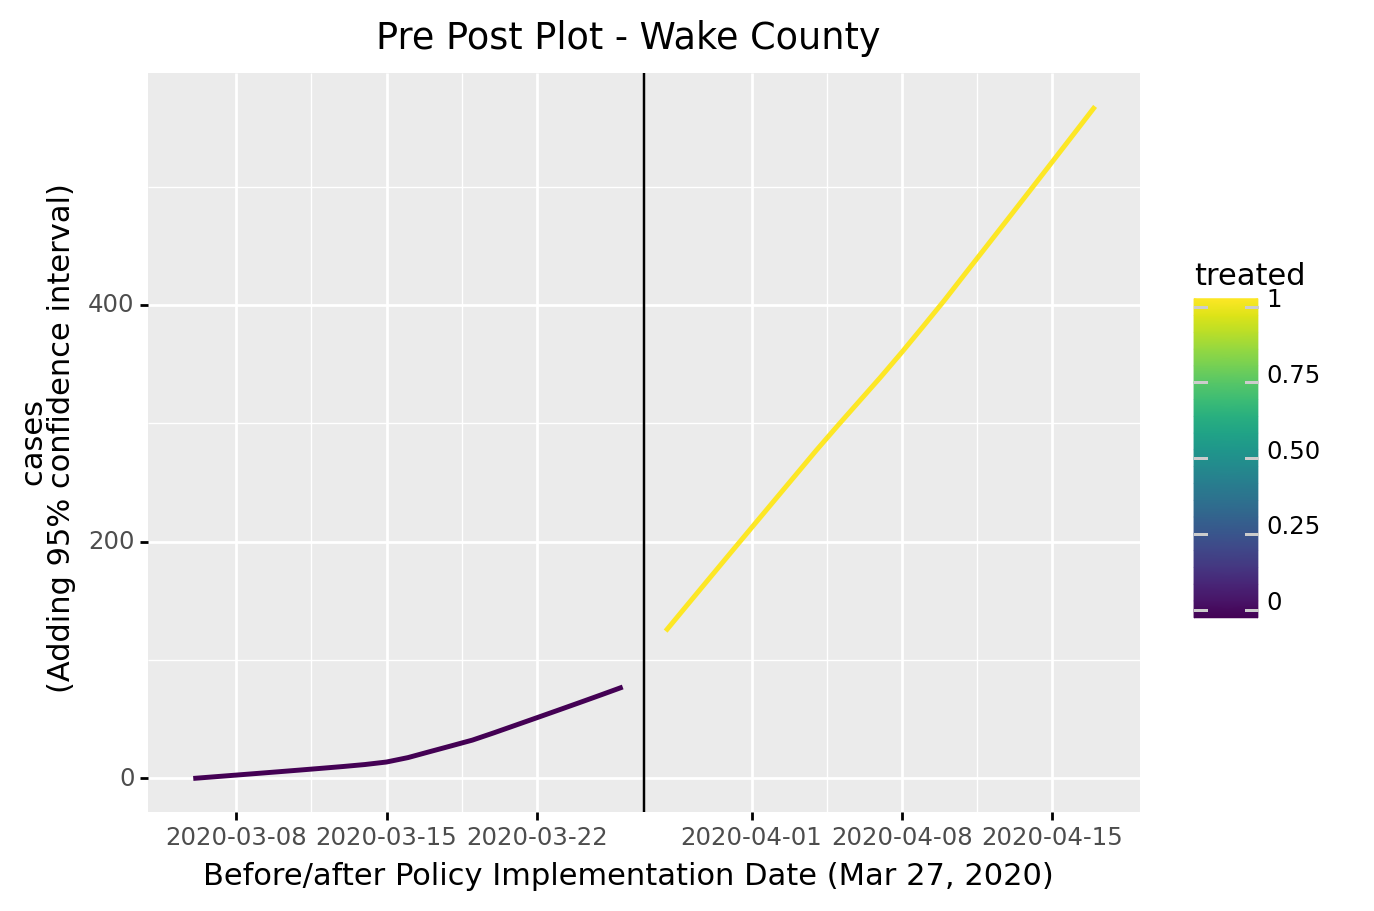

<ggplot: (8781918379650)>

<IPython.core.display.Javascript object>

In [13]:
# pre-post plot - Wake County
(ggplot() +
    geom_smooth(wake[wake['date'] < '2020-03-27'], 
                aes(x='date', y='cases', color='treated'), method='lowess') + 
    geom_smooth(wake[wake['date'] > '2020-03-27'], 
                aes(x='date', y='cases', color='treated'), method='lowess')
    + xlab('Before/after Policy Implementation Date (Mar 27, 2020)') 
    + ylab(str("cases") + ' \n(Adding 95% confidence interval)')
    + geom_vline(xintercept = '2020-03-27')
    + labs(title=str("Pre Post Plot - Wake County")))

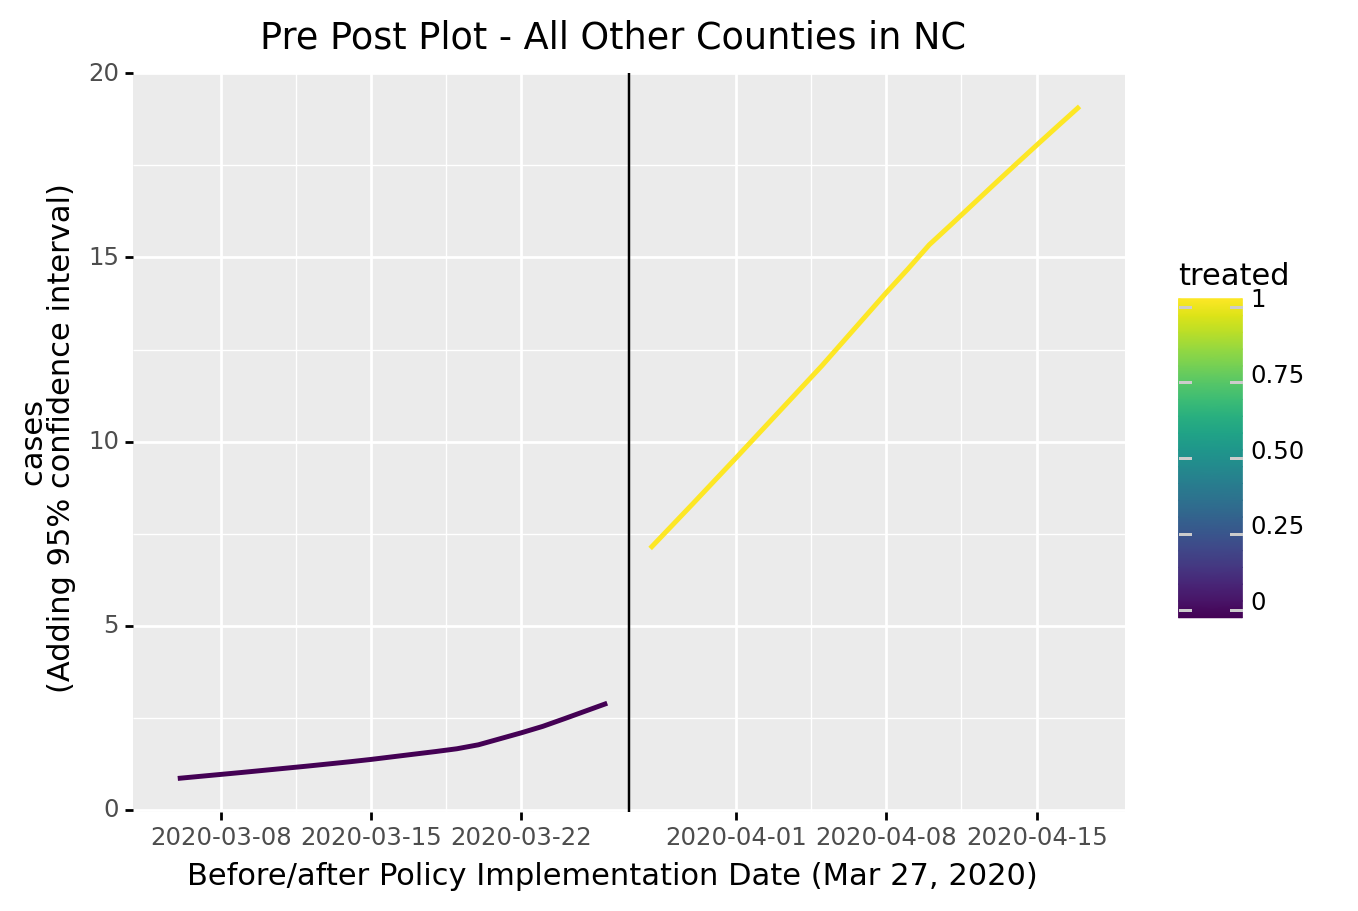

<ggplot: (8781918315508)>

<IPython.core.display.Javascript object>

In [14]:
# pre-post plot - control counties
(ggplot() +
    geom_smooth(other[other['date'] < '2020-03-27'], 
                aes(x='date', y='cases', color='treated'), method='lowess') + 
    geom_smooth(other[other['date'] > '2020-03-27'], 
                aes(x='date', y='cases', color='treated'), method='lowess')
    + xlab('Before/after Policy Implementation Date (Mar 27, 2020)') 
    + ylab(str("cases") + ' \n(Adding 95% confidence interval)')
    + geom_vline(xintercept = '2020-03-27')
    + labs(title=str("Pre Post Plot - All Other Counties in NC")))

In [15]:
# subset to top 5 counties based on population
control = other.loc[other['population'] > 300000]
control.county.unique()

array(['Forsyth', 'Mecklenburg', 'Durham', 'Guilford', 'Cumberland'],
      dtype=object)

<IPython.core.display.Javascript object>

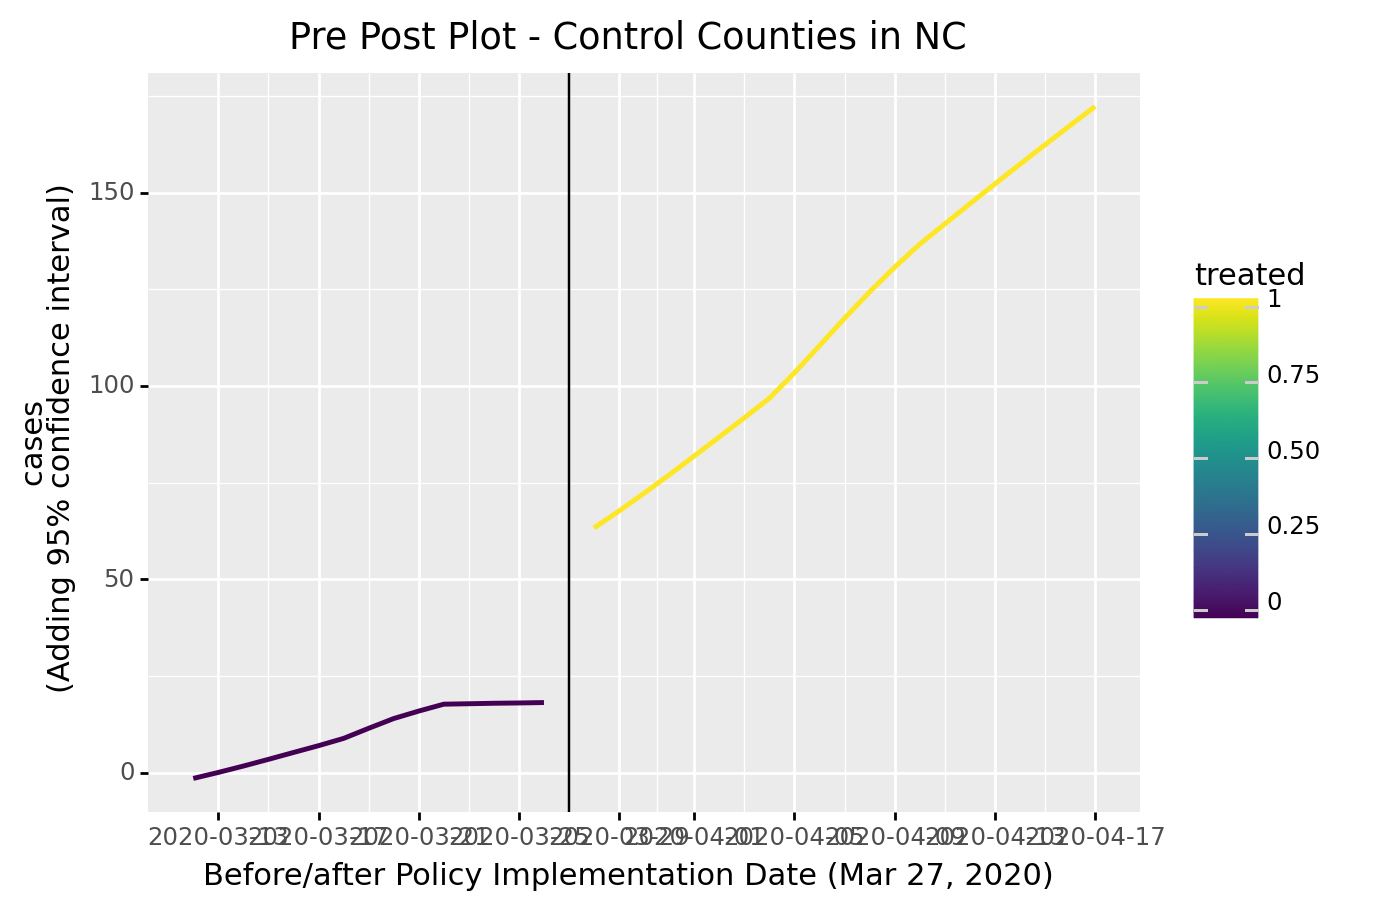

<ggplot: (8781918297007)>

<IPython.core.display.Javascript object>

In [16]:
# pre-post plot - control counties
(ggplot() +
    geom_smooth(control[control['date'] < '2020-03-27'], 
                aes(x='date', y='cases', color='treated'), method='lowess') + 
    geom_smooth(control[control['date'] > '2020-03-27'], 
                aes(x='date', y='cases', color='treated'), method='lowess')
    + xlab('Before/after Policy Implementation Date (Mar 27, 2020)') 
    + ylab(str("cases") + ' \n(Adding 95% confidence interval)')
    + geom_vline(xintercept = '2020-03-27')
    + labs(title=str("Pre Post Plot - Control Counties in NC")))

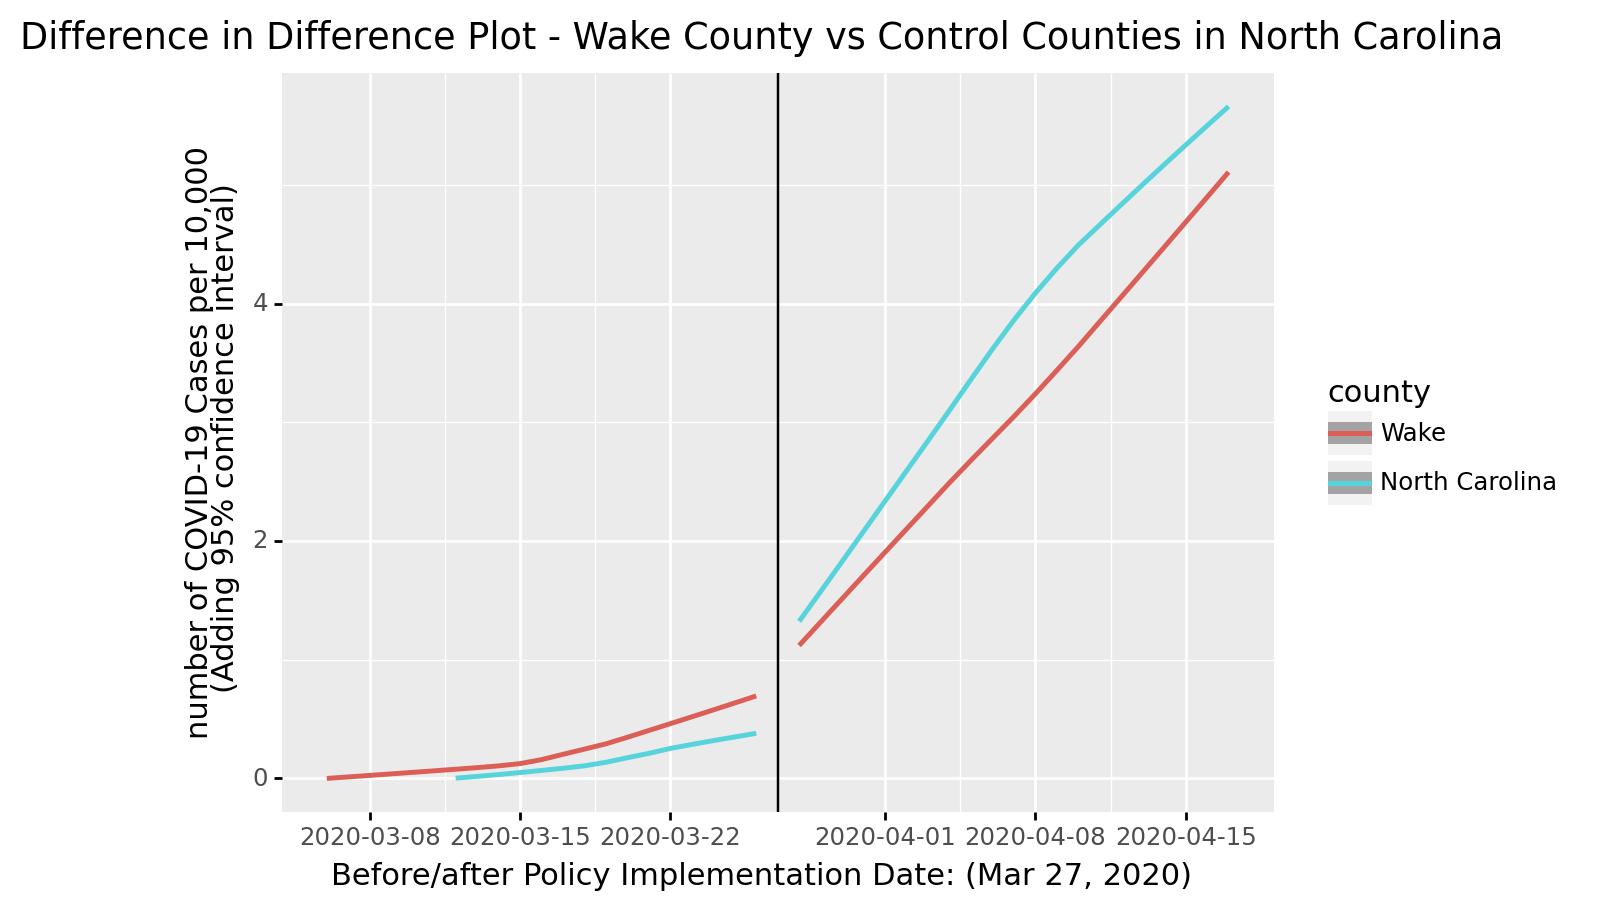

<ggplot: (8781918305799)>

<IPython.core.display.Javascript object>

In [17]:
# diff-in-diff plot - Wake vs control counties
(ggplot() +
    geom_smooth(wake[wake['date'] < '2020-03-27'], 
                aes(x='date', y='cases_standardized', color='county'), method='lowess') + 
    geom_smooth(wake[wake['date'] > '2020-03-27'], 
                aes(x='date', y='cases_standardized', color='county'), method='lowess') + 
        
    geom_smooth(control[control['date'] < '2020-03-27'], 
                aes(x='date', y='cases_standardized', color='state'), method='lowess') + 
    geom_smooth(control[control['date'] > '2020-03-27'], 
                aes(x='date', y='cases_standardized', color='state'), method='lowess')
    + geom_vline(xintercept = '2020-03-27')
    + xlab('Before/after Policy Implementation Date: (Mar 27, 2020)')
    + ylab(str("number of COVID-19 Cases per 10,000") + ' \n(Adding 95% confidence interval)')
    + labs(title=str("Difference in Difference Plot - Wake County vs Control Counties in North Carolina")))